In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
import timm

import pandas as pd
import numpy as np
from PIL import Image
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random
import os
import zipfile
import shutil
import warnings
warnings.filterwarnings('ignore')

In [100]:
 #zip_file_path = r'lungs_4classes.zip'

 #with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    #zip_ref.extractall('')

In [7]:
if torch.cuda.is_available():
    device = 'cuda'
else: device = 'cpu'

print(f"Using device: {device}")

Using device: cuda


## Splitting Train/Test
Since the data is originally structured as N subfolders in a directory corresponding to N classes, we want to divide them into the train/test sets, with the label distribution staying roughly the same.

In [2]:
dataset_path = './COVID-19_Radiography_Dataset/'

# Define image preprocessing pipeline: resize + normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Import original data with preprocessing
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split train/test set
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size 
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
class_names = dataset.classes

print(f"train_dataset: {len(train_dataset)}")
print(f"test_dataset: {len(test_dataset)}")

print(class_names)

train_dataset: 14815
test_dataset: 6350
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [3]:
# Create train/test directories
output_dir = './COVID-19_Radiography_Dataset_splitted_7030'
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def copy_images(dataset, split_dir):
    for i in range(len(dataset)):
        image_path, label = dataset.dataset.samples[dataset.indices[i]]
        class_name = dataset.dataset.classes[label]
        
        class_dir = os.path.join(split_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        shutil.copy(image_path, class_dir)

copy_images(train_dataset, train_dir)
copy_images(test_dataset, test_dir)

## Sample

Image shape: (299, 299, 3)
Image shape: (299, 299, 3)
Image shape: (299, 299, 3)
Image shape: (299, 299, 3)


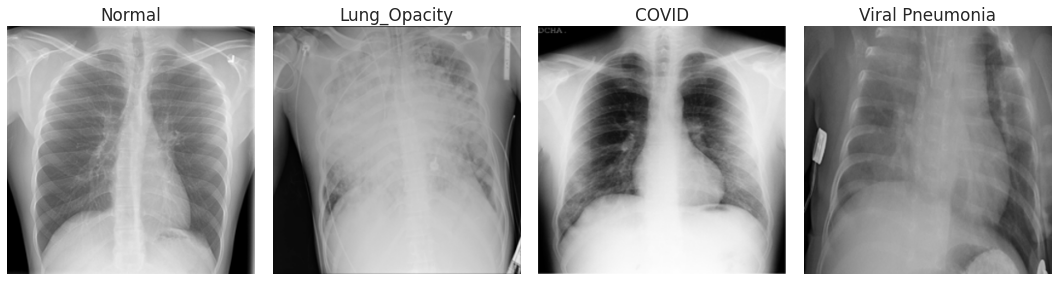

In [20]:
dataset_path = "COVID-19_Radiography_Dataset"
class_names = os.listdir(dataset_path)

fig, axs = plt.subplots(1, len(class_names), figsize=(15, 5))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    image_name = os.listdir(class_path)[9] 
    image_path = os.path.join(class_path, image_name)
    
    image = Image.open(image_path).convert('RGB')
    axs[i].imshow(image)
    axs[i].set_title(class_name)
    axs[i].axis('off')
    image_array = np.array(image)
    
    print("Image shape:", image_array.shape)

plt.tight_layout()
plt.show()

## Visualize label distribution

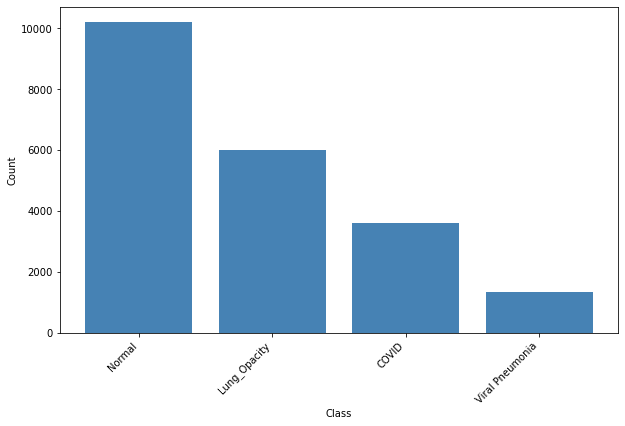

In [3]:
dataset_dir = "COVID-19_Radiography_Dataset"

classes = [subfolder for subfolder in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, subfolder))]
class_counts = {classname: len(os.listdir(os.path.join(dataset_dir, classname))) for classname in classes}

df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(10, 6))
plt.bar(df['Class'], df['Count'], color = 'Steelblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

## Data augmentation

In [ ]:
#random rotation
random_rotation_transformation_5 = T.Compose([
    T.RandomRotation((-7,-6)),
    T.CenterCrop((210,210)),
    T.Resize(size=(224,224))
])
random_rotation_transformation_minus5 = T.Compose([
    T.RandomRotation((6,7)),
    T.CenterCrop((210,210)),
    T.Resize(size=(224,224))
])
# random_rotation_transformation_65 = T.RandomRotation(65)

# random_crop = T.Compose([
#     T.RandomCrop((210,210)),
#     T.Resize(size=(224,224))
# ])


#Gausian Blur
gausian_blur_transformation_13 = T.GaussianBlur(kernel_size = (3,3), sigma = (6,8))
gausian_blur_transformation_56 = T.GaussianBlur(kernel_size = (3,3), sigma = (4 , 5))


#Gausian Noise
def addnoise(input_image, noise_factor = 0.13):
    inputs = T.ToTensor()(input_image)
    noisy = inputs + torch.rand_like(inputs) * noise_factor
    noisy = torch.clip (noisy,0,1.)
    output_image = T.ToPILImage()
    image = output_image(noisy)
    return image


#Random invert
random_invert_transform = T.RandomInvert()


#Main function that calls all the above functions to create 11 augmented images from one image
def augment_image(img_path):
    orig_img = Image.fromarray(img_path)

#     grayscale
#     grayscaled_image=grayscale_transform(orig_img)

#     random rotation
#     random_rotation_transformation_90_image = random_rotation_transformation_90(orig_img)
    random_rotation_transformation_5_image = random_rotation_transformation_5(orig_img)
    random_rotation_transformation_minus5_image = random_rotation_transformation_minus5(orig_img)


    #Gausian Blur
    gausian_blurred_image_13_image = gausian_blur_transformation_13(orig_img)
    gausian_blurred_image_56_image = gausian_blur_transformation_56(orig_img)
    
    #Gausian Noise
    gausian_image_3 = addnoise(orig_img)
    invert = random_invert_transform(orig_img)

    return [random_rotation_transformation_5_image,random_rotation_transformation_minus5_image,gausian_blurred_image_13_image,gausian_blurred_image_56_image,invert,gausian_image_3]

In [ ]:
dir = r'../COVID-19_Radiography_Dataset_splitted/aug_train_og_img_not_included'
if not os.path.exists(dir):
    os.makedirs(dir)

In [ ]:
l= []
num = 0
ind = random.sample(range(0, 3200), 725)
os.makedirs(os.path.join(dir, f'COVID'))

for i in Xcovid[ind]:
    l = augment_image(i)
    
    for img in l:
        img.save(os.path.join('../COVID-19_Radiography_Dataset_splitted/aug_train_og_img_not_included/COVID', f'saved_image{num}.png'))
        num += 1
        

In [ ]:
num = 0
ind = random.sample(range(0, 4200), 550)
os.makedirs(os.path.join(dir, f'Opacity'))

for i in Xopacity[ind]:
    l = augment_image(i)
    
    for img in l:
        img.save(os.path.join('../COVID-19_Radiography_Dataset_splitted/aug_train_og_img_not_included/Opacity', f'saved_image{num}.png'))
        num += 1

In [ ]:
num = 0
# ind = random.sample(range(0, 3200), 725)
os.makedirs(os.path.join(dir, f'Pneunomia'))

for i in Xpneu:
    l = augment_image(i)
    
    for img in l:
        img.save(os.path.join('../COVID-19_Radiography_Dataset_splitted/aug_train_og_img_not_included/Pneunomia', f'saved_image{num}.png'))
        num += 1

Image shape (Opacity - 1): (224, 224, 3)
Image shape (Opacity - 2): (224, 224, 3)
Image shape (Opacity - 3): (224, 224, 3)
Image shape (COVID - 1): (224, 224, 3)
Image shape (COVID - 2): (224, 224, 3)
Image shape (COVID - 3): (224, 224, 3)
Image shape (Pneunomia - 1): (224, 224, 3)
Image shape (Pneunomia - 2): (224, 224, 3)
Image shape (Pneunomia - 3): (224, 224, 3)


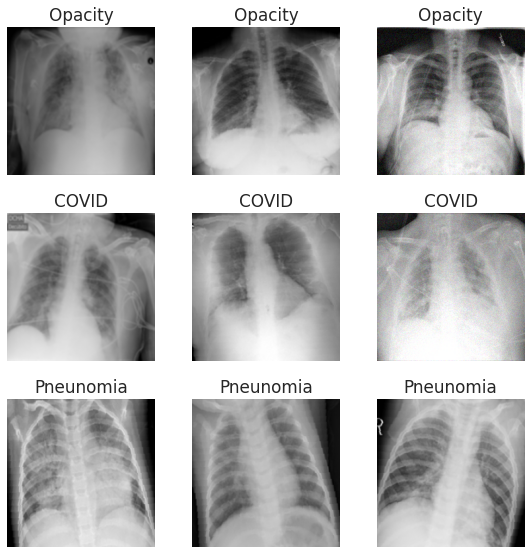

In [33]:
# Augmented Samples
dataset_path = "COVID-19_Radiography_Dataset_splitted/aug_train_og_img_not_included"
class_names = os.listdir(dataset_path)
fig, axs = plt.subplots(len(class_names), 3, figsize=(8, 8))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    
    for j in range(3): 
        image_name = os.listdir(class_path)[j] 
        image_path = os.path.join(class_path, image_name)
        
        image = Image.open(image_path).convert('RGB')
        axs[i, j].imshow(image)
        axs[i, j].set_title(class_name)
        axs[i, j].axis('off')
        image_array = np.array(image)
        
        print(f"Image shape ({class_name} - {j+1}):", image_array.shape)

plt.tight_layout()
plt.show()

## Data Load/Transform Pipeline

Mn nhớ bh để mà test model lấy acc thì mình load cụ thể thg splitted 80/20, 90/10, 70/30. Cái model mình train xong lưu state dict mình chỉ quan tâm thg chạy ổn nhất cho architecture đấy th.

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) 
])

# Import data from train and test folders
train_dataset = ImageFolder(root='./COVID-19_Radiography_Dataset_splitted_8020/train/', transform=transform)
test_dataset = ImageFolder(root='./COVID-19_Radiography_Dataset_splitted_8020/test/', transform=transform)

# Split train set to train and validation set
val_size = int(0.15 * len(train_dataset))
train_size = len(train_dataset)-val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
class_names = train_dataset.classes

print(f"train_dataset: {len(train_subset)}")
print(f"test_dataset: {len(test_dataset)}")
print(f"val_dataset: {len(val_subset)}")

print(class_names)

train_dataset: 12593
test_dataset: 6350
val_dataset: 2222
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [12]:
augmented_train_dataset = ImageFolder(root=r'./COVID-19_Radiography_Dataset_splitted/aug_train_og_img_not_included/', transform=transform)
combined_dataset = ConcatDataset([train_subset, augmented_train_dataset])

print(f"augmented train_dataset: {len(combined_dataset)}")
print(f"test_dataset: {len(test_dataset)}")
print(f"val_dataset: {len(val_subset)}")

augmented train_dataset: 13433
test_dataset: 6350
val_dataset: 2222


In [13]:
train_loader = DataLoader(train_subset, batch_size=24, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=24, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=24, shuffle=True)

## Beginning of training

In [50]:
base_lr = 0.001
batch_size = 24
base_batch_size = 32
warmup_epochs = 2 # 10% of total epochs
num_train_samples = 16151
epochs = 20
T_max = round(num_train_samples / batch_size * epochs)
display(T_max)

13459

In [51]:
# Define model 
model = timm.create_model('resnet18d', pretrained=True, num_classes = 4)
num_features = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_features, 4), nn.Softmax(dim=1))
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = base_lr)

# Define lr warm-up and cosine lr decay
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: min((epoch + 1) / warmup_epochs, 1))
cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0, last_epoch=-1)


In [52]:
display(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
   

In [53]:
num_epochs = 20
train_loss_values = [] 
train_acc_values = []
val_loss_values = []
val_acc_values = []
best_acc = 0
best_model_state = None


for epoch in range(num_epochs):
    scheduler.step()
    if epoch >= 2:  # Start updating the learning rate from the 3rd epoch onwards
        cosine.step() 
    
    # Train
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_acc_values.append(train_accuracy)

    # Evaluate
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        val_loss = criterion(outputs, labels)
        running_val_loss += val_loss.item()

        _, predicted_val = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted_val == labels).sum().item()

    val_accuracy = correct_val / total_val
    val_acc_values.append(val_accuracy)

    avg_loss = running_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_loader)
    train_loss_values.append(avg_loss)
    val_loss_values.append(avg_val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {(train_accuracy)*100:.4f}%, Val Acc: {(val_accuracy)*100:.4f}%')

    if val_accuracy > best_acc:
        best_acc = val_accuracy
        best_model_state = model.state_dict()
        print('==========================================================================================\nNew best model found 🔥🔥🔥🔥\n==========================================================================================')

if best_model_state is not None:
    torch.save(best_model_state, 'best_model_18d_4classes_valAcc_softmax_cosine_warmup_2ndAttempt.pth')
    print('Best model saved. 🙏🏼🙏🏼🙏🏼💯💯💯🗣🗣🗣💥💥💥')

Epoch [1/20], Train Loss: 0.8669, Val Loss: 0.8727, Train Acc: 88.0985%, Val Acc: 87.5744%
New best model found 🔥🔥🔥🔥
Epoch [2/20], Train Loss: 0.8244, Val Loss: 0.8156, Train Acc: 92.1567%, Val Acc: 92.7546%
New best model found 🔥🔥🔥🔥
Epoch [3/20], Train Loss: 0.8085, Val Loss: 0.8016, Train Acc: 93.6686%, Val Acc: 93.9797%
New best model found 🔥🔥🔥🔥
Epoch [4/20], Train Loss: 0.8008, Val Loss: 0.8141, Train Acc: 94.4981%, Val Acc: 92.8596%
Epoch [5/20], Train Loss: 0.7949, Val Loss: 0.7841, Train Acc: 95.0021%, Val Acc: 96.1148%
New best model found 🔥🔥🔥🔥
Epoch [6/20], Train Loss: 0.7911, Val Loss: 0.7867, Train Acc: 95.4168%, Val Acc: 95.6948%
Epoch [7/20], Train Loss: 0.7890, Val Loss: 0.7738, Train Acc: 95.6268%, Val Acc: 97.0249%
New best model found 🔥🔥🔥🔥
Epoch [8/20], Train Loss: 0.7824, Val Loss: 0.7758, Train Acc: 96.2096%, Val Acc: 96.7798%
Epoch [9/20], Train Loss: 0.7790, Val Loss: 0.7685, Train Acc: 96.5508%, Val Acc: 97.5849%
New best model found 🔥🔥🔥🔥
Epoch [10/20], Train Loss

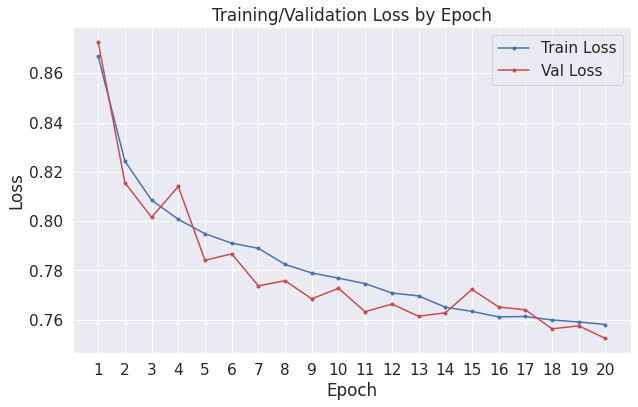

In [78]:
plt.figure(figsize = (10, 6))
plt.plot(range(1, num_epochs + 1), train_loss_values, marker='.', color = 'b', label = 'Train Loss')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, marker='.', color='r', label='Val Loss')
plt.title('Training/Validation Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.show()

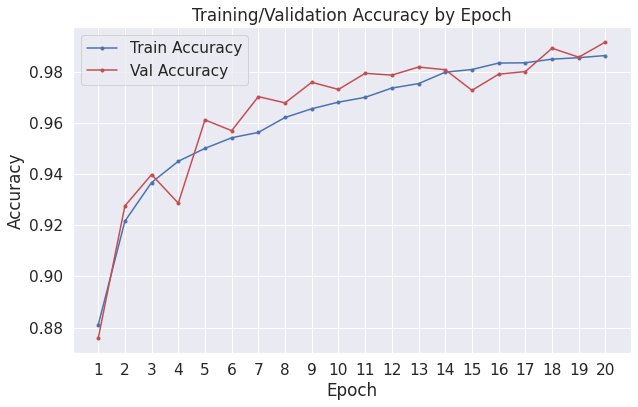

In [80]:
plt.figure(figsize = (10, 6))
plt.plot(range(1, num_epochs + 1), train_acc_values, marker='.', color = 'b', label = 'Train Accuracy')
plt.plot(range(1, len(val_acc_values) + 1), val_acc_values, marker='.', color='r', label='Val Accuracy')
plt.title('Training/Validation Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.show()

## Creating a new model instance to test

In [14]:
model = timm.create_model('resnet18d', pretrained=True, num_classes = 4)
num_features = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_features, 4), nn.Softmax(dim=1))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.load_state_dict(torch.load(r'best_model_18d_4classes_valAcc_softmax_cosine_warmup_2ndAttempt.pth'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


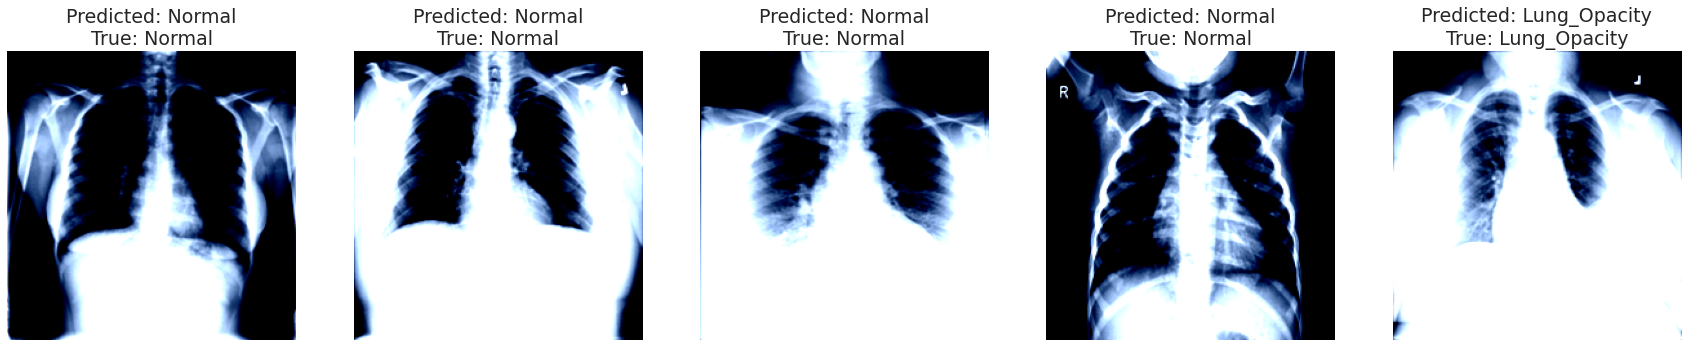

In [15]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    img_printed = 0
    fig, ax = plt.subplots(1, 5, figsize=(30, 10))
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        i, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            if img_printed >= 5:
                break
                
            image = images[i]
            label = labels[i].item()
            predicted_label = predicted[i].item()
            ax[img_printed].imshow(image.permute(1, 2, 0).cpu().numpy())
            ax[img_printed].set_title(f'Predicted: {class_names[predicted_label]}\nTrue: {class_names[label]}', fontsize=19)
            ax[img_printed].axis('off')
            img_printed += 1
        plt.show()

# accuracy = 100 * correct / total
#  print(f'Accuracy: {accuracy:.2f}%')

Test size: torch.Size([6350])


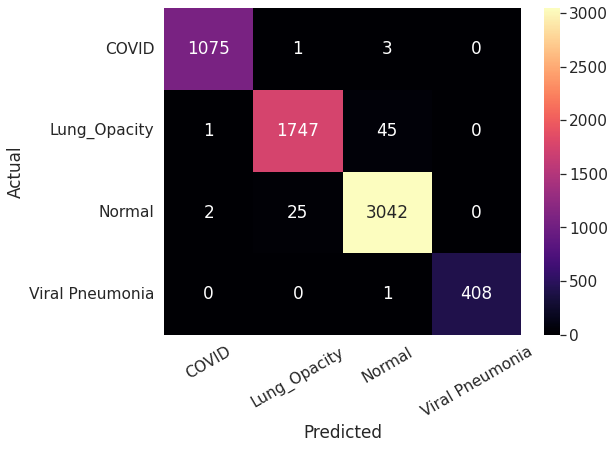


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1079
         1.0       0.99      0.97      0.98      1793
         2.0       0.98      0.99      0.99      3069
         3.0       1.00      1.00      1.00       409

    accuracy                           0.99      6350
   macro avg       0.99      0.99      0.99      6350
weighted avg       0.99      0.99      0.99      6350

Model Accuracy: 98.7717%


In [16]:
def evaluate_model(predictions, ground_truth):
    predictions = predictions.cpu().numpy()
    ground_truth = ground_truth.cpu().numpy()
    cm = confusion_matrix(ground_truth, predictions)
    report = classification_report(ground_truth, predictions)
    accuracy = np.mean(predictions == ground_truth)
    return cm, report, accuracy


all_labels = torch.Tensor().to(device)
all_predicteds = torch.Tensor().to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        i, predicted = torch.max(outputs.data, 1)
        
        all_labels = torch.cat((all_labels, labels), dim=0)
        all_predicteds = torch.cat((all_predicteds, predicted.float()), dim=0)

print(f'Test size: {all_predicteds.size()}')

cm, report, acc = evaluate_model(all_predicteds, all_labels)

# print("Confusion Matrix:")
# display(cm)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4) 
hm = sns.heatmap(cm, annot=True, fmt='d', cmap='magma', 
            xticklabels=['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'], 
            yticklabels=['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'])
hm.set_xticklabels(hm.get_xticklabels(), rotation=30)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(report)
print(f'Model Accuracy: {acc*100:.4f}%')

In [77]:
!nvidia-smi

Wed Oct  2 18:01:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        Off | 00000000:02:00.0  On |                  N/A |
| 30%   48C    P2              52W / 170W |   5930MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--